## Load Dependencies

In [12]:
# pip install tensorflow==2.11.0 tenosrflow_io==0.31.0

In [13]:
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
import numpy as np
import tensorflow.keras
import librosa

## CSV Dataset Loading

In [14]:
# https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
# https://www.tensorflow.org/tutorials/load_data/csv
'''train dataset'''
df_val_train = pd.read_csv("sample_archive/cv-valid-train.csv")
df_val_train['filename'] = 'sample_archive' + '/' + df_val_train['filename'].astype(str)
df_val_train = df_val_train[['filename', 'text']]
df_val_train.head()

,filename,text
0,sample_archive/cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...
1,sample_archive/cv-valid-train/sample-000001.mp3,everything in the universe evolved he said
2,sample_archive/cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...
3,sample_archive/cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...
4,sample_archive/cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...


In [15]:
'''test dataset'''
df_val_test = pd.read_csv("sample_archive/cv-valid-test.csv")
df_val_test['filename'] = 'sample_archive' + '/' + df_val_test['filename'].astype(str)
df_val_test = df_val_test[['filename', 'text']]
df_val_test.head()

,filename,text
0,sample_archive/cv-valid-test/sample-000000.mp3,without the dataset the article is useless
1,sample_archive/cv-valid-test/sample-000001.mp3,i've got to go to him
2,sample_archive/cv-valid-test/sample-000002.mp3,and you know it
3,sample_archive/cv-valid-test/sample-000003.mp3,down below in the darkness were hundreds of pe...
4,sample_archive/cv-valid-test/sample-000004.mp3,hold your nose to keep the smell from disablin...


In [16]:
df_val_train['filename'][0]
df_val_test['filename'][0]

'sample_archive/cv-valid-test/sample-000000.mp3'

## Load_wav_16k_mono()

In [17]:
# @tf.function
def load_wav_16k_mono(filename):
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [18]:
wave = load_wav_16k_mono(df_val_train['filename'][0])
nwave = load_wav_16k_mono(df_val_test['filename'][0])

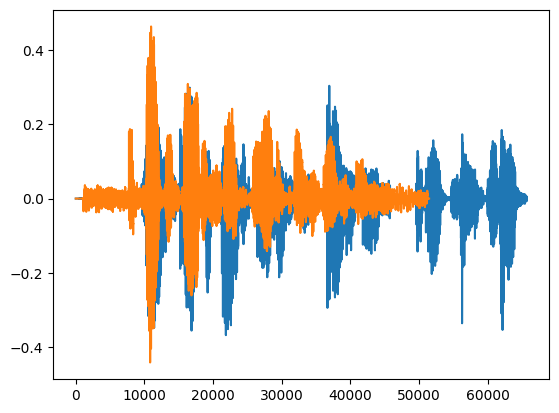

In [19]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

## Label

load text
https://www.tensorflow.org/tutorials/load_data/text
multiclass classification

In [20]:
dfvaltrain_fn = df_val_train['filename'].tolist()
dfvaltrain_txt = df_val_train['text'].tolist()

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dfvaltrain_txt)
sequences = tokenizer.texts_to_sequences(dfvaltrain_txt)

# Step 2: Vocabulary Creation
word_index = tokenizer.word_index

# Step 3: Padding
max_sequence_length = 30  # Define the maximum sequence length
sequences_padded= pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# # Step 4: Numerical Representation
# print(" (before processing):")
# print(dfvaltrain_txt)
# print("\nNumerical representation (after processing):")
# print(sequences_padded_train)
# print("\nVocabulary:")
# print(word_index)

In [22]:
# Create two separate TensorFlow Datasets from the lists
dfvaltrain_fn_dataset = tf.data.Dataset.from_tensor_slices(dfvaltrain_fn)
dfvaltrain_txt_dataset = tf.data.Dataset.from_tensors(sequences_padded)
# Combine the two datasets using the `zip` function
data = tf.data.Dataset.zip((dfvaltrain_fn_dataset, dfvaltrain_txt_dataset))
data

<ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(50, 30), dtype=tf.int32, name=None))>

## MFCC

In [23]:
# # https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505
# # audio, sample_rate = librosa.load([df_val_train['filename'][i] for i in df_val_train['filename']], sr=None, mono=True)
# audio, sample_rate = librosa.load(df_val_train['filename'][0], sr=None, mono=True)

In [24]:
# import sklearn.preprocessing
# mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate)
# # Center MFCC coefficient dimensions to the mean and unit variance
# scaler = sklearn.preprocessing.StandardScaler()
# mfcc = scaler.fit_transform(mfcc.T).T
# librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time')
# print (f'MFCC is of type {type(mfcc)} with shape {mfcc.shape}')


## Melspectogram

In [25]:
# sgram = librosa.stft(audio)
# librosa.display.specshow(sgram)

In [26]:
# # use the mel-scale instead of raw frequency
# sgram_mag, _ = librosa.magphase(sgram)
# mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
# librosa.display.specshow(mel_scale_sgram)

In [27]:
# mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
# librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')


## Preprocess()

https://www.tensorflow.org/tutorials/audio/simple_audio#convert_waveforms_to_spectrograms

In [28]:
# @tf.function
def preprocess(file_path,label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:20000]
    zero_padding = tf.zeros([20000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram,label

In [29]:
file_path,label= data.shuffle(buffer_size=1000).as_numpy_iterator().next()
print(file_path,'\n',label)
# label=tf.constant(label)

b'sample_archive/cv-valid-train/sample-000000.mp3' 
 [[ 39   2  84 ...   0   0   0]
 [ 87  14   1 ...   0   0   0]
 [  5  42  15 ...   0   0   0]
 ...
 [295   8  29 ...   0   0   0]
 [  5 299  59 ...   0   0   0]
 [ 15  82 300 ...   0   0   0]]


In [30]:
spectrogram,label = preprocess(file_path,label)
len(spectrogram)
# spectrogram.shape

616

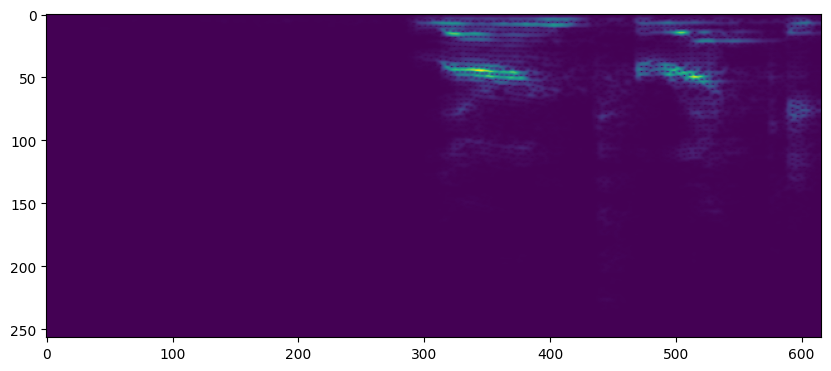

In [31]:
plt.figure(figsize=(10,5))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

## Pipeline, Train, Test

In [32]:
# tf.config.run_functions_eagerly(True)
data = data.map(preprocess) 
# data,label = preprocess(df_val_train)     #happening on filem=name column only 616
# data = tf.expand_dims(data, axis=0) 
# data = data.map(lambda filename, label: preprocess(filename,label))
data = data.cache()                             #616
data = data.shuffle(buffer_size=1000)           #616
data = data.batch(10)                           #62
data = data.prefetch(2)                         #62              
len(data)
data



AssertionError: in user code:

    File "C:\Users\shree\AppData\Local\Temp\ipykernel_3696\1727493022.py", line 3, in preprocess  *
        wav = load_wav_16k_mono(file_path)
    File "C:\Users\shree\AppData\Local\Temp\ipykernel_3696\3785415839.py", line 3, in load_wav_16k_mono  *
        res = tfio.audio.AudioIOTensor(filename)
    File "C:\Users\shree\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow_io\python\ops\audio_ops.py", line 663, in __init__  **
        assert dtype is not None, "dtype must be provided in graph mode"

    AssertionError: dtype must be provided in graph mode


: 

In [ ]:
train = data.take(40)
test = data.skip(40).take(22)
len(train)
train

In [ ]:
# element = train.as_numpy_iterator().next()
samples= train.as_numpy_iterator().next()
# samples_4d = tf.expand_dims(samples, axis=0)
samples.shape

## Model CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(616,257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.compile('Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

fit model,view loss,kpi plots

In [ ]:
# hist = model.fit(train, epochs=4, validation_data=test)

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(X_test)

In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]